# Impact of unreliable news-sharing on the emergence of polarized sub-communities in social media sites

In this simulation we will: <br>
1- Generate a number of news articles that origniate from different news sources. The articles are predetermined whether to be fake or not. <br>
2- Then we will create a number of users with different attitudes towards news and capture the effect of fake news on perceiving real news. <br>
3- The main finiding we aim to have here is that with more fake news being generated, there will be an increase in misclassifying real news

## 1. Set thresholds and parameters to be used during the simulation

In [1]:
from SocialNetwork import *
from SimHelper import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import random
from random import shuffle, randint
from tqdm import tqdm_notebook as tqdm
import networkx as nx
from pprint import pprint
import pickle
import seaborn as sns 

#distributions
from scipy.stats import bernoulli, norm, truncnorm, expon, gamma, beta

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix,accuracy_score

from pipelinehelper import PipelineHelper 

In [2]:
%matplotlib inline

#### Set simulation hyperparameters and create the network

In [3]:
#overall number of users
NUM_USERS = 250 

#overall number of sources
NUM_SOURCES = 50 

#overall number of news events
NUM_NEWS = 100 

#measure the avergage connectivity of the graph -- make it a percentage, connectivity resemlbles power law distribution
AVERAGE_DEGREE_OF_GRAPH = 80

#the starting point of where news sources are biased -- why not neutral, or more (add # new sources)
NEWS_SOURCE_BIAS_PROB = 0.5 

#the starting point of where news sources are biased -- (add # groups )
USER_BIAS_PROB = 0.001 

#probability that a news source has an intent to deceive -- justify it from thrid party sources
RELIABLE_NEWS_SOURCE_PROB = 0.1 

#probability that a news article is fake -- 
FAKE_NEWS_PERCENTAGE = 0.35 

In [4]:
#create an empty graph that will hold the connections
G = nx.Graph()

#create empty dictionaries for storing news articles, news sources, and users
NEWS_EVENTS = {}
NEWS_SOURCES = {}
USERS = {}

#create empty dataframes for storing news articles, news sources, and users
NEWS_SOURCES_DF = pd.DataFrame(columns=['news_source_id','bias','reliable'])
USERS_DF = pd.DataFrame(columns=['user_id','bias','analytical'])
NEWS_EVENTS_DF = pd.DataFrame(columns=['news_article_id','source_id','source_bias','sentiment','num_shares','fake'])

## 2. Define functions

generate_weighted_percentage <br>
generate_weighted_sentiment <br>
generate_num_of_shares <br>
generate_bias

### 2.1 Function to return either 0 or 1 by random within a given weight 

### Test random binary function

In [5]:
counter = 0

for i in range(1000):
    if generate_weighted_percentage(.3)==1:
        counter += 1
print("With weighted-percentage=0.3, the expected successes should be around 0.3. Success ratio =",counter/1000)

With weighted-percentage=0.3, the expected successes should be around 0.3. Success ratio = 0.299


### 2.2 Function to return a random sentiment using a beta distribution

In [6]:
%%latex
$$ f_X(x:\alpha,\beta) = \frac{\Gamma(\alpha +
\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha - 1}(1 - x)^{\beta - 1}$$

<IPython.core.display.Latex object>

In [7]:
get_beta_probs(0.8,1.4)

(0.42, 0.27, 0.2, 0.11)

1.0 0.5818909090909091 0.3117393939393939 0.11384444444444443


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

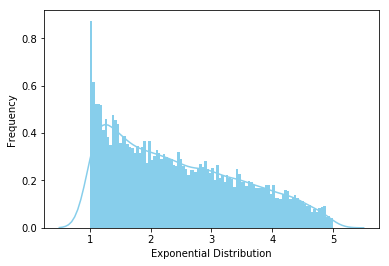

In [8]:
s4 = []
s3 = []
s2 = []
s1 = []
for _ in range(1,100):
    data_expon = beta.rvs(0.8,1.4,size=10000)
    x = np.interp(data_expon, (data_expon.min(), data_expon.max()), (1, 5))
    s4.append(len(np.where(x>=4)[0]))
    s3.append(len(np.where(x>=3)[0]))
    s2.append(len(np.where(x>=2)[0]))
    s1.append(len(np.where(x>=1)[0]))
print(np.mean(s1)/np.mean(s1),np.mean(s2)/np.mean(s1),np.mean(s3)/np.mean(s1),np.mean(s4)/np.mean(s1))

ax = sns.distplot(x,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Exponential Distribution', ylabel='Frequency')

In [9]:
generate_weighted_sentiment()

-3.27

### Plot sentiment distribution function

Testing positive_negative
With mu=0.5, the expected output should be around 0. Actual output= 0.002

Testing sentiment in range [-5,-1][1,5]


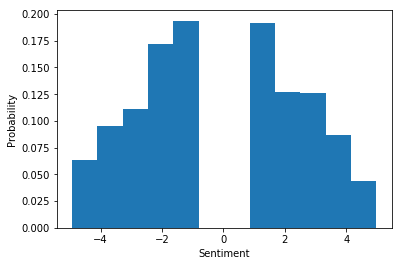

In [13]:
print('Testing positive_negative')
values = []
counter = 0

for i in range(1000):
    x = positive_or_negative(0.5)
    values.append(x)
        
print("With mu=0.5, the expected output should be around 0. Actual output=",sum(values)/1000)


print('\nTesting sentiment in range [-5,-1][1,5]')
values = []
for i in range(1000):
    values.append(generate_weighted_sentiment())
    
plt.hist(values,density=1, bins=12) 
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.show()

### 2.3 Function to return a number of shares given a loc and scale

### Test random number of shares with mean and standard distribution function

With loc= 1 and scale= 300, the values higher than 2000 are= 0.0011


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

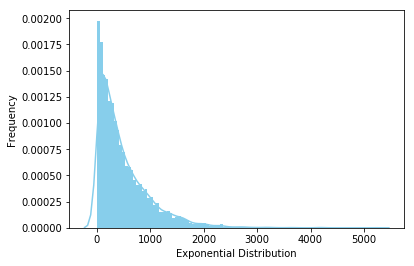

In [11]:
values = []
for i in range(10000):
    num_shares = generate_num_of_shares(1,300)
    if num_shares > 2000:
        values.append(1)
print("With loc= 1 and scale= 300, the values higher than 2000 are=",sum(values)/10000)

# print(generate_num_of_shares(10,2))
data_expon = expon.rvs(scale=500,loc=1,size=10000)
ax = sns.distplot(data_expon,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Exponential Distribution', ylabel='Frequency')

### 2.4 Function to return a user's bias given a mean and standard distribution

### Test user biases with mean and standard distribution function

Testing bias in range [-1,1]


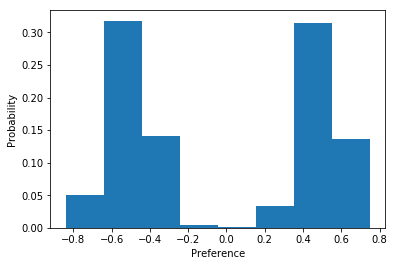

In [24]:
print('Testing bias in range [-1,1]')
values = []
for i in range(1000):
    values.append(generate_bias(0.5,1))

weights = np.ones_like(values)/float(len(values))
plt.hist(values, bins=8,weights=weights)    

# plt.hist(values, bins=8, normed=0) 
plt.xlabel('Preference')
plt.ylabel('Probability')
plt.show()

### 2.5 Function to return average degree of a graph

### Test the average degree function

In [13]:
y = nx.Graph()
y.add_edge('100','101')
y.add_edge('102','101')
y.add_edge('100','102')

average_degree_of_graph(y)

2.0

### 2.6 Function to find if two nodes are connected in a graph

### Test the nodes connected function

In [14]:
#add a few sources for testing
G.add_node('1000000')
G.add_node('1000001')
G.add_edge('1000000','1000001')

#add a few users for testing
G.add_node('8000000')
G.add_node('8000001')
G.add_node('8000005')
G.add_node('8000006')
G.add_node('8000007')
G.add_edge('8000000','1000001')
G.add_edge('8000000','8000001')
G.add_edge('8000001','8000005')
G.add_edge('8000000','8000006')
G.add_edge('8000006','8000007')

print('Expectation is that nodes \'1000000\' and \'1000001\' are connected')
print('nodes \'8000000\' and \'8000005\' are not connected')
print('and  node \'1000002\' is not in the network \n')

try:
    print("Testing connection '1000000','1000001':",nodes_connected(G,'1000000','1000001'))
    print("Testing connection '8000000','8000005':",nodes_connected(G,'8000000','8000005'))
    print("Testing connection '1000000','1000002':",nodes_connected(G,'1000000','1000002'))
except Exception as e:
    print("Exception:",str(e))

Expectation is that nodes '1000000' and '1000001' are connected
nodes '8000000' and '8000005' are not connected
and  node '1000002' is not in the network 

Testing connection '1000000','1000001': True
Testing connection '8000000','8000005': False
Exception: The node 1000002 is not in the graph.


### 2.7 Two functions to find a neighbor's neighbor

In [15]:
connected_users = [user for user in list(G.nodes) if G[user] != {}]
print("Before test:")
print("Neighbors of 8000000:",list(G.neighbors('8000000')))
print("Neighbors of 1000001:",list(G.neighbors('1000001')))
print("Neighbors of 8000001:",list(G.neighbors('8000001')))
print("Neighbors of 8000006:",list(G.neighbors('8000006')))

print("\nTesting ...")
try:
    print("For user : 8000000")
    print("First neighbor",get_random_neighbor(G,'8000000'))
    print("Second neighbor",get_second_random_neighbor(G,'8000000'))
except Exception as e:
    print(str(e))

Before test:
Neighbors of 8000000: ['1000001', '8000001', '8000006']
Neighbors of 1000001: ['1000000', '8000000']
Neighbors of 8000001: ['8000000', '8000005']
Neighbors of 8000006: ['8000000', '8000007']

Testing ...
For user : 8000000
First neighbor 8000006
Second neighbor 8000005


In [16]:
def clear_the_network_from_prev_shares():
    for user in USERS:
        USERS[user].news_articles.clear()
    for news_source in NEWS_SOURCES:
        NEWS_SOURCES[news_source].news_articles.clear()
    print('Network cleared')

C:\Users\abdal\AppData\Local\conda\conda\envs\simulations\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


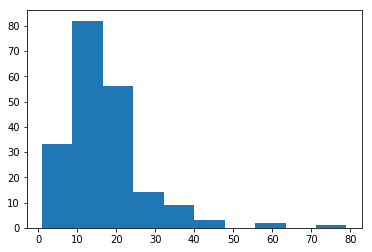

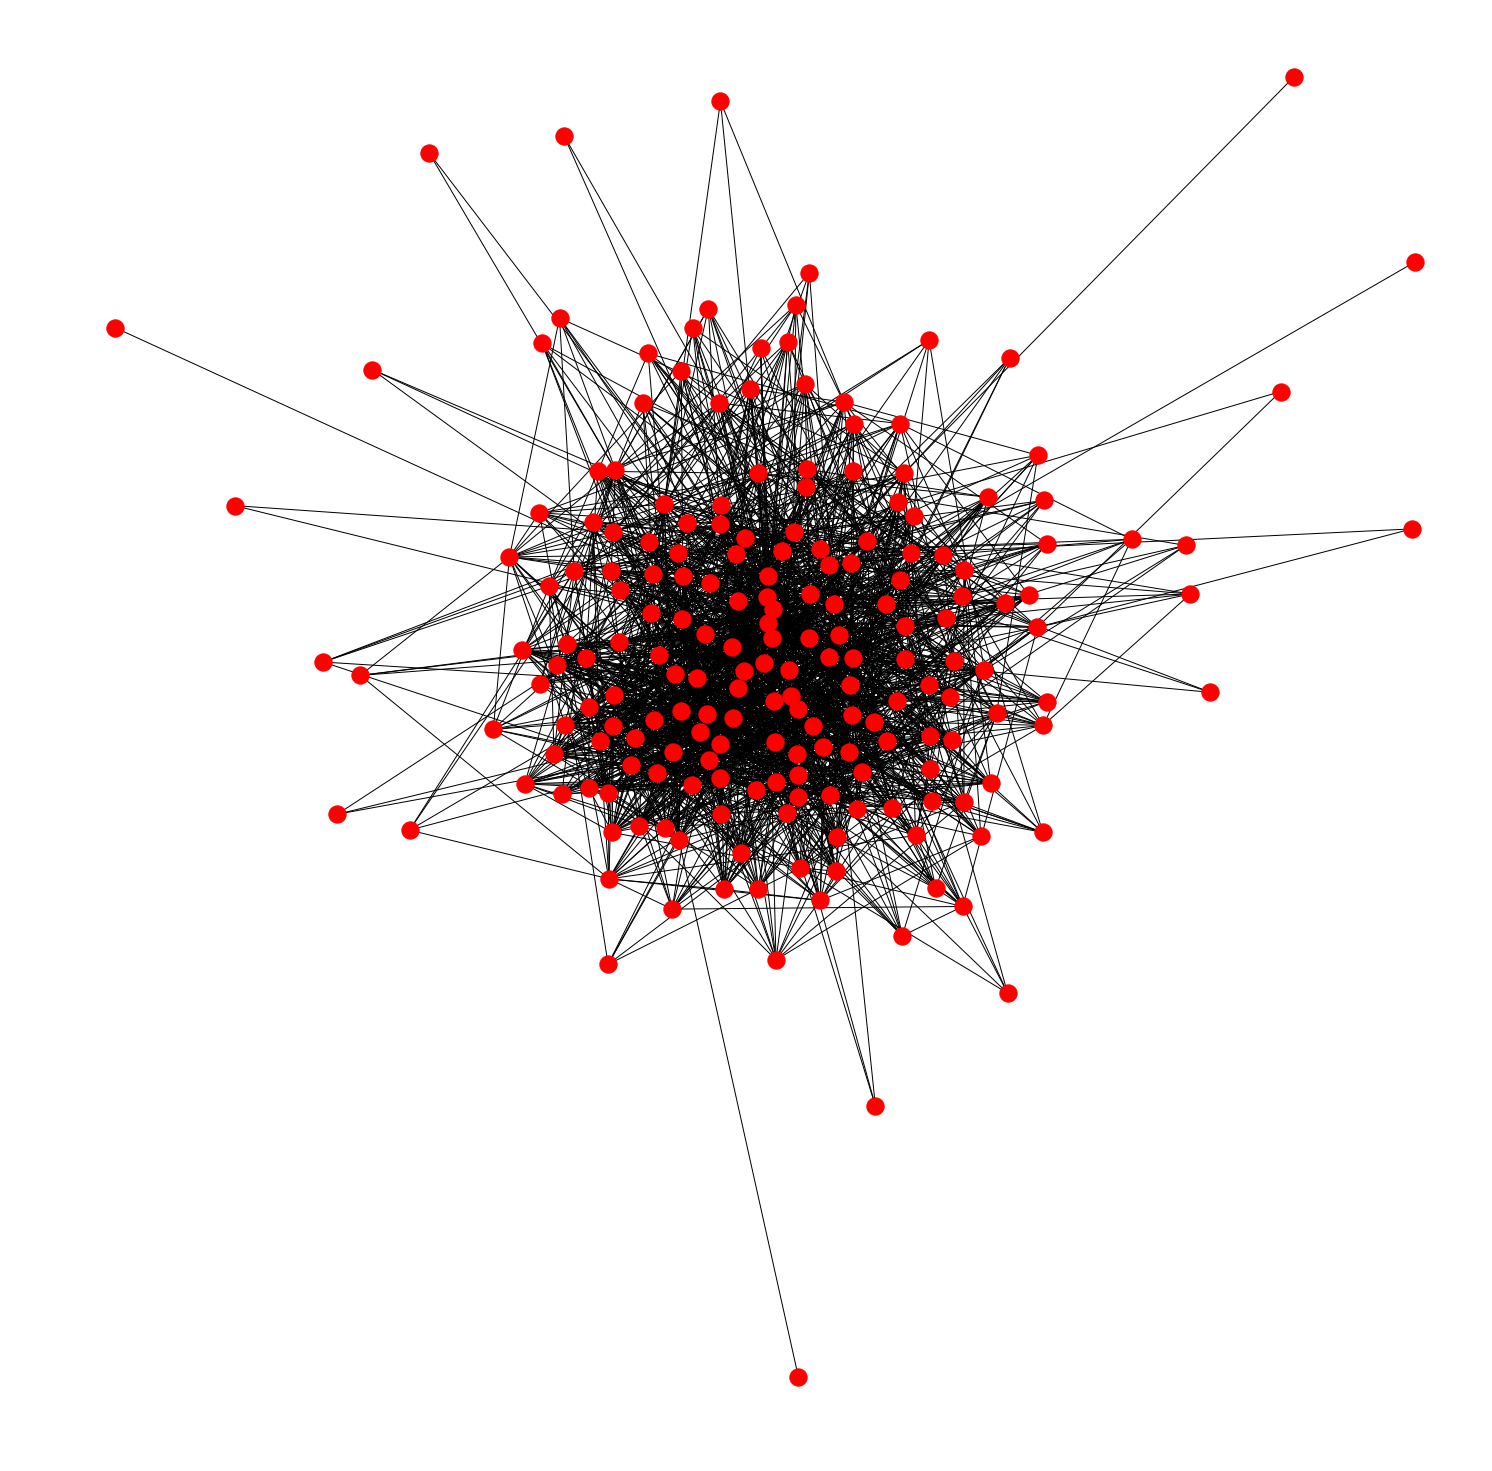

20.85

In [17]:
G = nx.Graph()

users = 200

user_base = 10000
for i in range(0,users):
    G.add_node(user_base+i)

create_initial_connections(G)
average_degree_of_graph(G)

### DIGRESSION - ON CREATING GRAPHS USING GEOGRAPHICAL THRESHOLD

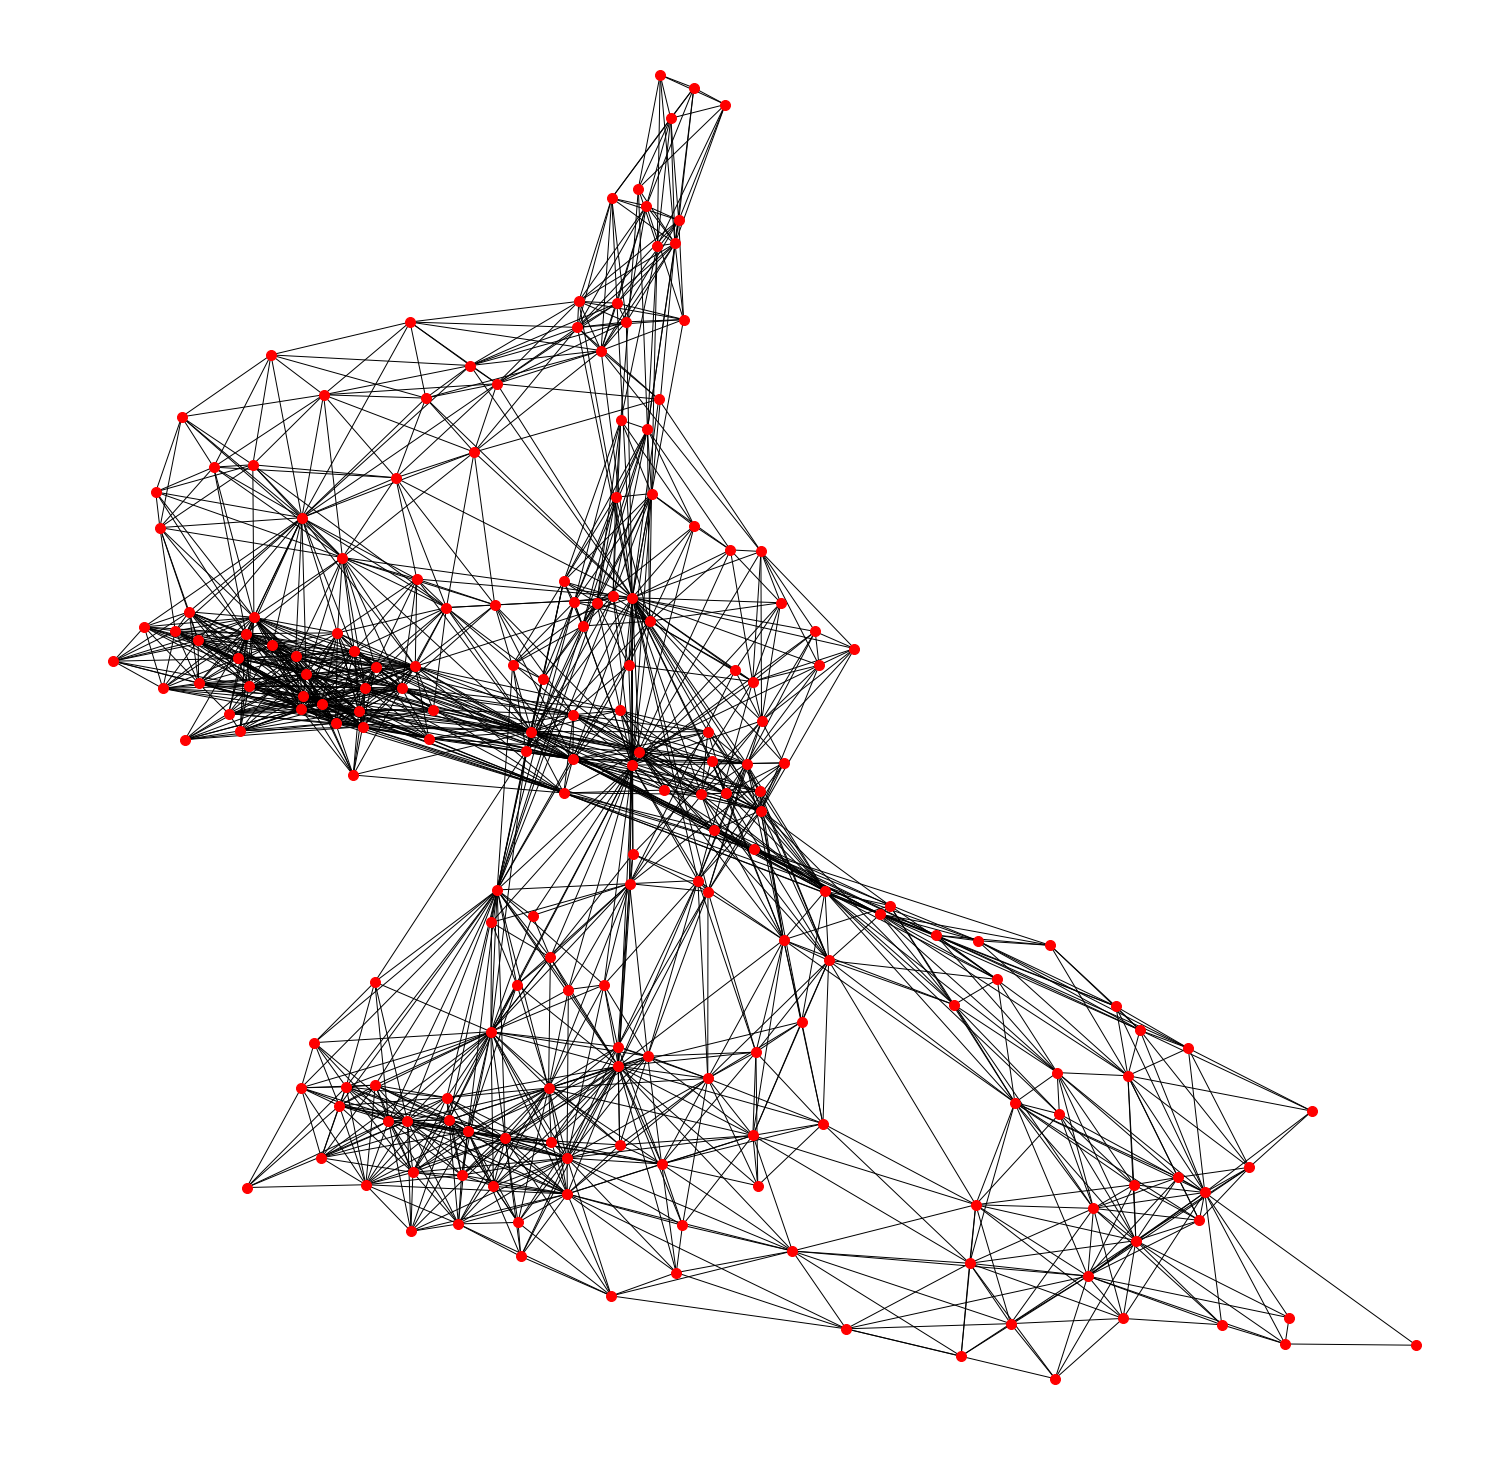

15.2

In [18]:
G = nx.geographical_threshold_graph(200, 60)
plt.figure(2,figsize=(20,20))
nx.draw_spring(G,node_size=100,font_size=8) 
plt.show()
average_degree_of_graph(G)

(array([13., 73., 41., 30., 13., 12., 13.,  3.,  1.,  1.]),
 array([ 2. ,  6.6, 11.2, 15.8, 20.4, 25. , 29.6, 34.2, 38.8, 43.4, 48. ]),
 <a list of 10 Patch objects>)

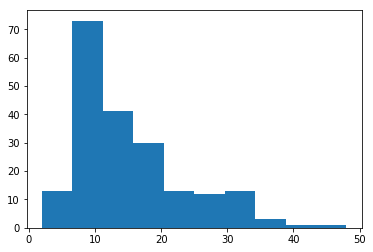

In [19]:
x = []
for node in list(G.nodes()):
    x.append(len(list(G.edges(node))))
#     print(len(list(G.edges(node))))
plt.hist(x,bins=10)

In [20]:
len([i for i in x if i < 10]) 

57

In [21]:
len(x)

200

### END DIGRESSION

## 3. Define classes for the agents and news

### Test NewsArticle
Create a news article with a sentiment of 2.4, 3 shares, and categorized as fake

In [22]:
n_article = NewsArticle(news_article_id=1000000,source_id=100,source_bias=0.5,sentiment=2.4,num_shares=3,fake=1)
print("News article id:"+str(n_article.news_article_id)+"\nfrom source: "+str(n_article.source_id)+"\nsource bias: "+
      str(n_article.source_bias)+"\nfake score="+str(n_article.fake)+"\nsentiment of: "+str(n_article.sentiment)+
      "\nnumber of shares:"+str(n_article.num_shares))

News article id:1000000
from source: 100
source bias: 0.5
fake score=1
sentiment of: 2.4
number of shares:3


### Test NewsSource
Create a news source at the beginning of the sources and have it with an intent to deceive online viewers. <br> 
Also create add the previous news article to the news source

In [23]:
n_source = None
n_source = NewsSource(news_source_id=100,bias=0,reliable=1,news_articles=[]) 
n_source.add_article(n_article)
print("News source "+str(n_source.news_source_id)+": "+str(len(n_source.news_articles))+" articles added")

print("News source id:"+str(n_source.news_source_id)+"\nbias:"+str(n_source.bias)+"\nreliability: "+
      str(n_source.reliable)+"\nnumber of articles:"+str(len(n_source.news_articles)))

News source 100: 1 articles added
News source id:100
bias:0
reliability: 1
number of articles:1


In [24]:
print(n_source.news_articles[0].num_shares)

3


### Test UserAgent
Create an agent with a medium bias of 0.5 and generate source credibility for all news sources in the simulation. <br>
Also define if the user is analytical (analyzes the news articles) or not 

### Digression - Detecting communities using networkx

In [25]:
from networkx.algorithms import community
G = nx.barbell_graph(5, 1)
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

[[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]

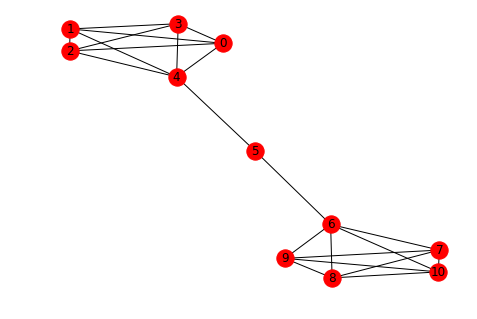

In [26]:
nx.draw_spring(G,with_labels=True)

In [27]:
# G = nx.DiGraph(nx.path_graph(4))
pr = nx.pagerank(G, alpha=0.9)

In [28]:
pr

{0: 0.09053828674995734,
 1: 0.09053828674995734,
 2: 0.09053828674995734,
 3: 0.09053828674995734,
 4: 0.1129675371639048,
 6: 0.1129675371639048,
 7: 0.09053828674995734,
 8: 0.09053828674995734,
 9: 0.09053828674995734,
 10: 0.09053828674995734,
 5: 0.04975863167253174}

## End Digression

In [29]:
clear_the_network_from_prev_shares()

u_agent = UserAgent(100001,0.5,0)
print("User "+str(u_agent.user_id)+" with bias of: "+str(u_agent.bias)+" and "+str(u_agent.source_credibility)+" source credibility")
print("User "+str(u_agent.user_id)+" analytical score = "+str(u_agent.analytical))



#create random news sources to test the functions of the agent
news_sources = {}
count = 0

for i in range(NUM_SOURCES):
    #for each news source create basic parameters index, bias, and reliability
    source_base = 100
    news_sources[source_base+i] = NewsSource(source_base+i,
                                             generate_bias(0.5,2),
                                             generate_weighted_percentage(.2))
    
    #generate news articles for each news source
    news_articles = []
    for j in range(random.randint(100,200)):
        article_base = 10000
        
        #generate sentiment
        sentiment = generate_weighted_sentiment()
        sentiment_score = (2**abs(sentiment)/2**5)
        
        #generate num_shares appropriate to the sentiment
        if generate_weighted_percentage(sentiment_score) == 1:
            lower_bound = 2
            upper_bound = NUM_USERS*0.02
        else:
            lower_bound = int(abs(sentiment))
            upper_bound = int(abs(sentiment))**int(abs(sentiment))+1
        num_shares = generate_num_of_shares(random.randint(lower_bound,upper_bound),lower_bound)
        num_shares_score = num_shares/(NUM_USERS)
        
        # generate a fake score
        # where a fake score is a function of source credibility, sentiment, and number of shares 
        similarity_in_bias = abs(u_agent.bias - news_sources[source_base+i].bias)
        similarity_in_bias = similarity_in_bias/2
        similarity_in_bias = 1- similarity_in_bias
        similarity_in_bias = round(similarity_in_bias - abs(u_agent.bias - 0.2),2)
        source_credibility_score = abs(similarity_in_bias)
        
        fake_score = (1/3)*sentiment_score + (1/3)*num_shares_score + (1/3)*source_credibility_score
        
        fake = generate_weighted_percentage(fake_score)
        
        #add the news articles
        news_articles.append(NewsArticle(article_base+j,source_base+i,news_sources[source_base+i].bias,sentiment,num_shares,fake))
        news_sources[source_base+i].add_article(news_articles[j])
        count += 1
        
print('Generated:',len(news_sources),'sources and ',count,'articles')



#add news articles to a list
for n in news_sources:
    for news_article in news_sources[n].news_articles:
#         print(len(n))
        u_agent.news_articles.append(news_article)
print("Added : "+str(len(u_agent.news_articles))+" news articles")
print('\n')

#test generating source credibility
u_agent.generate_source_credibility(news_sources)
print("User "+str(u_agent.user_id)+" with new source credibility : "+str(u_agent.source_credibility))
print('\n')

#test the agent's classifier
u_agent.train_classifier()

Network cleared
User 100001 with bias of: 0.5 and {} source credibility
User 100001 analytical score = 0
Generated: 50 sources and  7498 articles
Added : 7498 news articles


source: 128 ,similarity: 0.69 credibility: 1
source: 129 ,similarity: 0.46 credibility: 1
source: 130 ,similarity: 0.03 credibility: 0
source: 131 ,similarity: 0.57 credibility: 0
source: 132 ,similarity: 0.64 credibility: 1
source: 133 ,similarity: 0.23 credibility: 0
source: 134 ,similarity: 0.66 credibility: 1
source: 135 ,similarity: 0.66 credibility: 0
source: 136 ,similarity: 0.67 credibility: 1
source: 137 ,similarity: 0.62 credibility: 1
source: 138 ,similarity: 0.27 credibility: 1
source: 139 ,similarity: 0.14 credibility: 0
source: 140 ,similarity: 0.04 credibility: 0
source: 141 ,similarity: 0.14 credibility: 1
source: 142 ,similarity: 0.2 credibility: 0
source: 143 ,similarity: 0.68 credibility: 1
source: 144 ,similarity: 0.17 credibility: 1
source: 145 ,similarity: 0.64 credibility: 1
source: 146 ,sim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   34.8s finished




Train Accuracy ::  0.7881913569269073
Test Accuracy  ::  0.7786666666666666
Mean Absolute Error: 0.22
Root Mean Square Error: 0.47


{'classifier__selected_model': ('svm', {'C': 1.0, 'gamma': 'auto'}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}
0.7858794237951272


### Training a default classifier

In [30]:
df = pd.DataFrame(columns=['analytical','source_credibility','sentiment','num_shares','fake'])
print('populating the dataframe')

TRAIN_LENGTH = 100000
analytical = []
source_credibility = []
sentiment = []
num_shares = []
fake= []
for i in tqdm(range(TRAIN_LENGTH)):
    analytical_score = generate_weighted_percentage(.05)
    analytical.append(analytical_score)
    
    source_credibility_score = random.random()
    source_credibility.append(source_credibility_score)
    
    sentiment_score = generate_weighted_sentiment()
    sentiment.append(sentiment_score)
    
    # when there is extremely high sentiment and low source credibility
    # generate a relatively lower number of shares with some exceptions
    epsilon = random.random()
    if abs(sentiment_score)>4 and source_credibility_score <0.6 and epsilon <0.8:
        num_shares_score = generate_num_of_shares(np.log(NUM_USERS),2)
    else:
        num_shares_score = random.randint(0,NUM_USERS)
    num_shares.append(num_shares_score)
    
    if (analytical_score == 1) or  (source_credibility_score > 0.8):
        fake_score = generate_weighted_percentage(0.01)
    else:
        fake_score = generate_weighted_percentage(((abs(sentiment_score)/5)+(num_shares_score/NUM_USERS))/2)
    fake.append(fake_score)
df['analytical']=analytical
df['source_credibility']=source_credibility
df['sentiment']=sentiment
df['num_shares']=num_shares
df['fake']=fake

populating the dataframe


In [31]:
df.describe()

analytical  source_credibility      sentiment    num_shares  \
count  100000.000000       100000.000000  100000.000000  100000.00000   
mean        0.050090            0.501437       0.005701     118.64870   
std         0.218132            0.289504       2.692185      75.50614   
min         0.000000            0.000030      -5.000000       0.00000   
25%         0.000000            0.250467      -2.280000      51.00000   
50%         0.000000            0.502756       1.000000     118.00000   
75%         0.000000            0.752572       2.280000     184.00000   
max         1.000000            0.999956       5.000000     250.00000   

                fake  
count  100000.000000  
mean        0.367540  
std         0.482138  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [32]:
df.tail(50)

analytical  source_credibility  sentiment  num_shares  fake
99950           1            0.282809      -2.67         111     0
99951           0            0.418899      -1.68          14     0
99952           0            0.912109       3.23          25     0
99953           0            0.918666       1.03          34     0
99954           0            0.319954      -1.68           4     0
99955           0            0.733571       1.17         248     0
99956           0            0.624832      -1.25          83     0
99957           0            0.660440       3.95         169     1
99958           0            0.796839       2.53         216     1
99959           0            0.293328       2.95         234     1
99960           0            0.386060      -1.71         174     1
99961           0            0.178593      -3.67           6     0
99962           0            0.528413       1.11         119     1
99963           0            0.581039      -2.39          90     0
99964           0            0.238962       1.14          75     0
99965           0            0.854802      -2.57         237     0
99966           0            0.273694      -1.33         122     0
99967           0            0.627116      -2.35         143     0
99968           0            0.532126       2.98         209     1
99969           0            0.533256       4.38           7     0
99970           0            0.895983      -2.50         138     0
99971           0            0.907379       3.30         230     0
99972           0            0.866166      -3.57          74     0
99973           0            0.473876      -1.08          15     0
99974           0            0.003485       2.93         159     0
99975           0            0.120794       2.82         184     0
99976           0            0.569784       2.98         209     1
99977           0            0.155083       4.63           9     0
99978           0            0.761030       1.71          45     0
99979           0            0.594972       2.73          41     0
99980           0            0.805897      -3.00         138     0
99981           0            0.531826      -1.45         110     0
99982           0            0.068068       4.06           8     0
99983           0            0.627402      -3.92         200     1
99984           0            0.806396       2.58          84     0
99985           0            0.497292       1.32          56     1
99986           0            0.881716       1.84         162     0
99987           0            0.395236      -3.43          72     1
99988           0            0.166253       2.35          19     0
99989           0            0.970851       2.81         157     0
99990           0            0.550874      -1.12         137     1
99991           0            0.348243      -2.02          51     0
99992           0            0.534105      -1.00         151     0
99993           0            0.325552       1.24          76     0
99994           0            0.335496      -2.13          41     0
99995           0            0.478379       1.72          69     0
99996           0            0.927073      -2.44          38     0
99997           0            0.294918       2.85          47     0
99998           0            0.549856      -1.20         238     1
99999           0            0.192552       1.64          66     0

In [33]:
# Labels are the values we want to predict
DV = np.array(df['fake'])
# Remove the labels from the features
# axis 1 refers to the columns
df = df.drop('fake', axis = 1)
# Saving feature names for later use
feature_list = list(df.columns)

# Convert to numpy array
IVs = np.array(df)
train_IVs , test_IVs, train_DV, test_DV = train_test_split(IVs, DV, test_size = 0.01, random_state = 42)

In [132]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(train_IVs, train_DV)

In [34]:
# filename = 'random_forset.sav'
filename = 'grid_search_cv.sav'
try:
    grid_search_cv = pickle.load(open(filename, 'rb'))
except:
    grid_search_cv = GridSearchCV(pipe, params, scoring='accuracy', verbose=1, cv=4, n_jobs=-1)
#     rf=RandomForestClassifier(n_estimators =100,n_jobs=2, min_samples_leaf=2,random_state=0)
    grid_search_cv.fit(train_IVs, train_DV)

    # Use the forest's predict method on the test data
    #         print(type(test_IVs))
    predictions = grid_search_cv.best_estimator_.predict(test_IVs)

    # Train and Test Accuracy
    print("Train Accuracy :: ", accuracy_score(train_DV, grid_search_cv.best_estimator_.predict(train_IVs)))
    print("Test Accuracy  :: ", accuracy_score(test_DV, predictions))

    # Calculate the absolute errors
    errors = abs(predictions - test_DV)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Root Mean Square Error:',round(np.sqrt(np.mean((errors)**2)),2))


    # save the model to disk
    pickle.dump(grid_search_cv, open(filename, 'wb'))

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 124.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 210.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 211.0min finished


Train Accuracy ::  0.714989898989899
Test Accuracy  ::  0.719
Mean Absolute Error: 0.28
Root Mean Square Error: 0.53


In [35]:
grid_search_cv.cv_results_['split3_test_score']

array([0.71174593, 0.67089579, 0.71174593, 0.67089579, 0.69938179,
       0.71178633, 0.63986424, 0.70964483, 0.63941977, 0.71004889,
       0.71562487, 0.6937654 , 0.71562487, 0.6937654 , 0.70677603,
       0.71550366, 0.64826862, 0.71324094, 0.64196533, 0.71279648,
       0.69336135, 0.69307851, 0.6908966 , 0.69194715, 0.69388662,
       0.68911875, 0.68762374, 0.68911875, 0.68984605, 0.68536102,
       0.67388581, 0.65307689, 0.67388581, 0.65307689, 0.67384541,
       0.68123965, 0.65938018, 0.68123965, 0.65938018, 0.68220938,
       0.66980484, 0.64939998, 0.66980484, 0.64939998, 0.66992606,
       0.67756273, 0.65558204, 0.67756273, 0.65558204, 0.67752232,
       0.494323  , 0.49452503, 0.494323  , 0.49452503, 0.494323  ,
       0.67493636, 0.67493636, 0.67493636, 0.67489596, 0.67497677])

In [236]:
# from keras.models import Sequential
# from keras.layers import Dense

# # define the keras model
# model = Sequential()
# model.add(Dense(512, input_dim=4, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(2048, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

# # compile the keras model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit the keras model on the dataset
# model.fit(train_IVs, train_DV, epochs=150, batch_size=64, verbose=2)

# # evaluate the keras model
# _, accuracy = model.evaluate(test_IVs, test_DV, verbose=2)

# accuracy

Using TensorFlow backend.


## 4. Simulation

### 4.1 Create news sources

In [89]:
G = nx.Graph()

In [90]:
"""
The goal from the first step of the simulation is to create the news sources where news originate
Each source gets a unique id, along with a generated bias and reliability
We aim to find a network of news sources that represents the state we want to recreate from the dataset
"""
#Create news sources with an id, index, bias, and deception intent
if len(NEWS_SOURCES)> 0:
    G = nx.Graph()
    NEWS_SOURCES = {}
    NEWS_SOURCES_DF = pd.DataFrame(columns=['news_source_id','bias','reliable'])

    
source_base = 1000000
while NEWS_SOURCES_DF.reliable.sum() < 2:#ensure there is at least 2 reliable news source
    #reset dataframe in case of while loop
    NEWS_SOURCES_DF = NEWS_SOURCES_DF.iloc[0:0]
    
    #create news sources with an id, reliability, and bias. Then add it to the graph, dictionary, and dataframe
    for news_source in range(NUM_SOURCES):
        #id
        news_source_id = source_base+news_source
        #bias
        bias = generate_bias(NEWS_SOURCE_BIAS_PROB,1)
        #reliability
        reliable = generate_weighted_percentage(RELIABLE_NEWS_SOURCE_PROB)
        
        #add to dictionary, dataframe, and graph
        NEWS_SOURCES[source_base+news_source] =  NewsSource(news_source_id, #news_source_id
                                                     bias, #bias for the news source
                                                     reliable) #score for how reliable a news source can be
        NEWS_SOURCES_DF = NEWS_SOURCES_DF.append(pd.Series([news_source_id,bias,reliable],
                                                           index=NEWS_SOURCES_DF.columns) , ignore_index=True)

        G.add_node(source_base+news_source)

    #Connect news sources to each other based on their similarity in bias along with a random chance of them not being connected
    color_map = []
    for news_source in NEWS_SOURCES:
        if NEWS_SOURCES[news_source].bias > 0.3:
            color_map.append('blue')
        elif NEWS_SOURCES[news_source].bias > -0.3:
            color_map.append('khaki')
        else:
            color_map.append('red')

        for other_news_source in NEWS_SOURCES:
            if news_source != other_news_source:
                diff = abs(NEWS_SOURCES[news_source].bias - NEWS_SOURCES[other_news_source].bias)
                similarity = (2-diff)/2
                connect = generate_weighted_percentage(similarity)
                if connect == 1:
                    G.add_edge(news_source,other_news_source,weight = similarity)

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 1069
Average degree:  42.7600


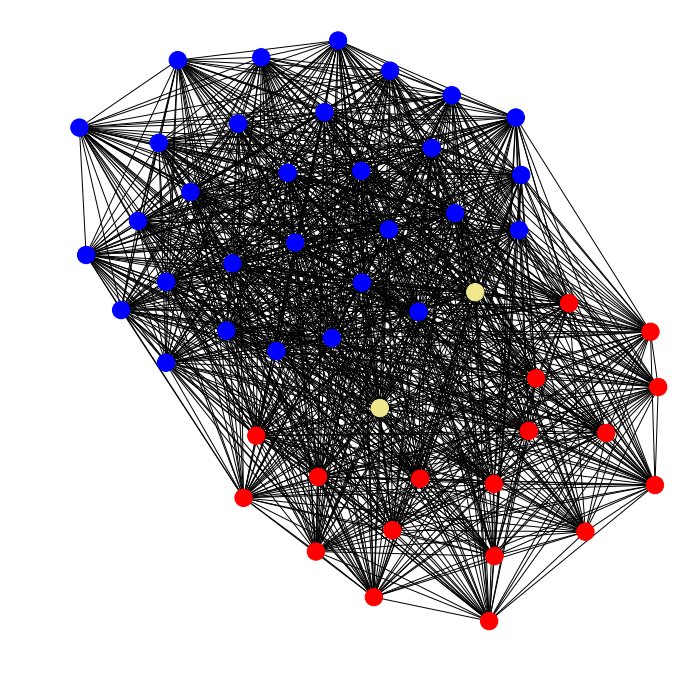

In [91]:
print(nx.info(G))

plt.figure(3,figsize=(9,9)) 
nx.draw_spring(G,node_color=color_map,with_labels=False)
plt.show()

In [92]:
print(G[1000000])

{1000002: {'weight': 0.965}, 1000006: {'weight': 0.585}, 1000008: {'weight': 0.9550000000000001}, 1000009: {'weight': 0.55}, 1000010: {'weight': 0.54}, 1000011: {'weight': 0.5}, 1000012: {'weight': 0.95}, 1000013: {'weight': 0.91}, 1000014: {'weight': 0.605}, 1000017: {'weight': 0.49}, 1000018: {'weight': 0.915}, 1000020: {'weight': 0.555}, 1000021: {'weight': 0.59}, 1000022: {'weight': 0.515}, 1000025: {'weight': 0.64}, 1000026: {'weight': 0.575}, 1000028: {'weight': 0.51}, 1000030: {'weight': 0.925}, 1000031: {'weight': 0.98}, 1000032: {'weight': 0.535}, 1000033: {'weight': 0.6}, 1000035: {'weight': 0.935}, 1000036: {'weight': 0.485}, 1000039: {'weight': 0.94}, 1000040: {'weight': 0.46499999999999997}, 1000041: {'weight': 0.86}, 1000042: {'weight': 0.47}, 1000043: {'weight': 0.575}, 1000046: {'weight': 0.91}, 1000047: {'weight': 0.985}, 1000048: {'weight': 0.89}, 1000049: {'weight': 0.99}, 1000001: {'weight': 0.94}, 1000003: {'weight': 0.59}, 1000004: {'weight': 0.885}, 1000005: {'we

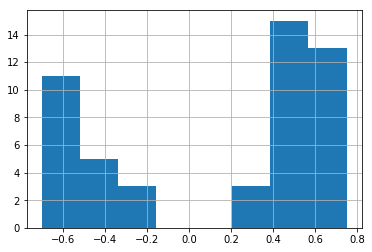

In [93]:
NEWS_SOURCES_DF.bias.hist(bins=8)

In [94]:
NEWS_SOURCES_DF.reliable.value_counts()

0.0    46
1.0     4
Name: reliable, dtype: int64

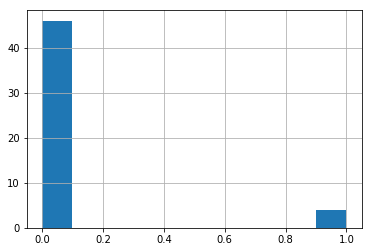

In [95]:
NEWS_SOURCES_DF.reliable.hist()

### 4.2 Create a number of users that will read the news articles and determine if they are fake or real

creating users



creating user connections



connecting users to sources


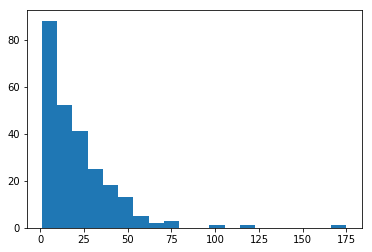

In [96]:
"""
The goal from the second step of the simulation is to create the users who will read/share news
Each user gets a unique id, along with a generated bias and their analytical ability
The users will perform tasks such as assessing the credibility of each news source
    and store new articles somewhere were they can read them
    and classify the news they look at, in order to do that they have to occasionally train their classifier
We aim to add the users to the network
"""
print('creating users')
U = nx.Graph()

#Create news sources with an id, index, bias, and deception intent
if len(USERS)> 0:
    USERS = {}
    USERS_DF = pd.DataFrame(columns=['user_id','bias','analytical'])

user_base = 8000000
for user in tqdm(range(NUM_USERS)):
    user_id = user_base+user
    bias = generate_bias(USER_BIAS_PROB,2)
    analytical = generate_weighted_percentage(.05)
    USERS[user_base+user] =  UserAgent(user_id,#user_id
                                       bias, #bias for the user
                                       analytical,
                                    classifier=grid_search_cv) #
    USERS_DF = USERS_DF.append(pd.Series([user_id,bias,analytical],
                                                       index=USERS_DF.columns) , ignore_index=True)
    
    U.add_node(user_base+user)

print('creating user connections')
create_initial_connections(U,graph_display=False)
G.add_nodes_from(U)
G.add_edges_from(U.edges())

print('connecting users to sources')
"""
Connect users to each other based on a small random chance as it is highly unlikely for any random two people to know each other
and connect users to news sources based on their similarity in bias along with a random chance of them not being connected
"""
for user in USERS:
    if USERS[user].bias > 0.3:
        color_map.append('lightblue')
    elif USERS[user].bias > -0.3:
        color_map.append('silver')
    else:
        color_map.append('coral')

    for news_source in NEWS_SOURCES:
        diff = abs(NEWS_SOURCES[news_source].bias - USERS[user].bias)
        similarity = (2-diff)/2
        connect_bias = generate_weighted_percentage(similarity)
        connect_random = generate_weighted_percentage(0.01)
        if (connect_bias == 1) and (connect_random == 1) :
            G.add_edge(news_source,user,weight = similarity)
    
#     for other_user in USERS:
#         if user != other_user:
#             connect = generate_weighted_percentage(0.005)
#             if connect == 1:
#                 G.add_edge(user,other_user,weight = 1)

### explore the dynamic evolution of the network

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 4800
Average degree:  32.0000


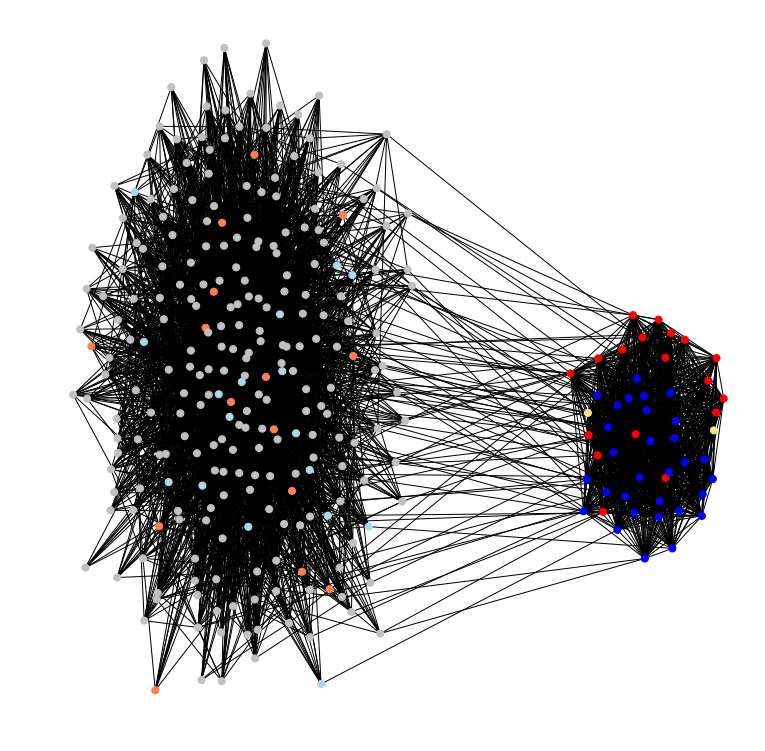

In [97]:
print(nx.info(G))

plt.figure(3,figsize=(10,10)) 
nx.draw_spring(G,node_color=color_map,with_labels=False,node_size = 50)
plt.show()

the platform has classifiers per source, each one is different. This can help with determining policy

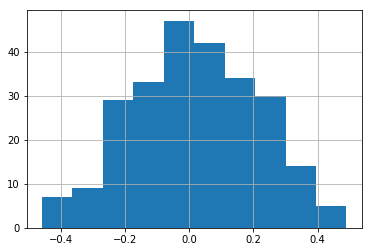

In [98]:
USERS_DF.bias.hist()

In [99]:
USERS_DF.analytical.value_counts()

0.0    242
1.0      8
Name: analytical, dtype: int64

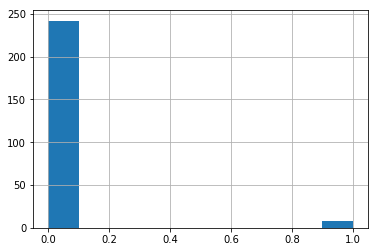

In [100]:
USERS_DF.analytical.hist()

# SKIP UNTIL CONTINUE

In [101]:
connected_users = [user for user in USERS if G[user] != {}]
connected_users_length = [len(G[user]) for user in connected_users]

Text(0, 0.5, 'Probability')

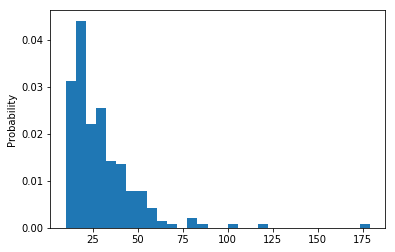

In [102]:
x = np.asarray(connected_users_length)
plt.hist(x, density=True, bins=30)
plt.ylabel('Probability')

In [290]:
for user in USERS:
    if len(G[user]) <2:
        random_user = random.choice(connected_users)
        while random_user == user:
            random_user = random.choice(connected_users)
        random_weight = random.random()
        G.add_edge(user,random_user,weight = random_weight)
        connect = generate_weighted_percentage(random_weight)
        while connect == 1:
            random_user = random.choice(list(G[random_user].keys()))
            random_weight = random.random()
            G.add_edge(user,random_user,weight = random_weight)
            connect = generate_weighted_percentage(random_weight)
        connected_users = [user for user in USERS if G[user] != {}]
        connected_users_length = [len(G[user]) for user in connected_users]

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 1610
Average degree:  10.7333


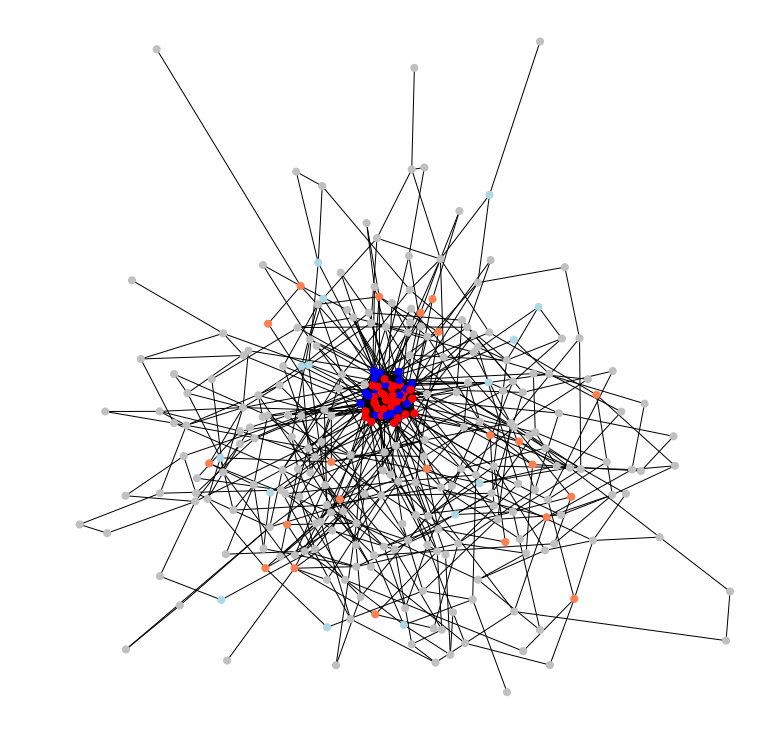

In [291]:
print(nx.info(G))

plt.figure(3,figsize=(10,10)) 
nx.draw_spring(G,node_color=color_map,with_labels=False,node_size = 50)
plt.show()

In [292]:
while average_degree_of_graph(G) < AVERAGE_DEGREE_OF_GRAPH:
    for user in USERS:
        try:
            random_user = get_second_random_neighbor(user)
            random_weight = random.random()
            G.add_edge(user,random_user,weight = random_weight)
        except:
            print('couldnt find second neighbor')
        connect = generate_weighted_percentage(random_weight)
        while connect == 1:
            try:
                random_user = get_second_random_neighbor(user)
                random_weight = random.random()
                G.add_edge(user,random_user,weight = random_weight)
            except:
                print('couldnt find second neighbor')
            connect = generate_weighted_percentage(random_weight)
    print(average_degree_of_graph(G))
connected_users_length = [len(G[user]) for user in connected_users]

couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
could not find a second neighbor for 8000080
could not find a second neighbor for 8000100
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
could not find a second neighbor for 8000199
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
14.1728
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find second neighbor
couldnt find sec

In [293]:
G.remove_node(None)

Name: 
Type: Graph
Number of nodes: 300
Number of edges: 12454
Average degree:  83.0267


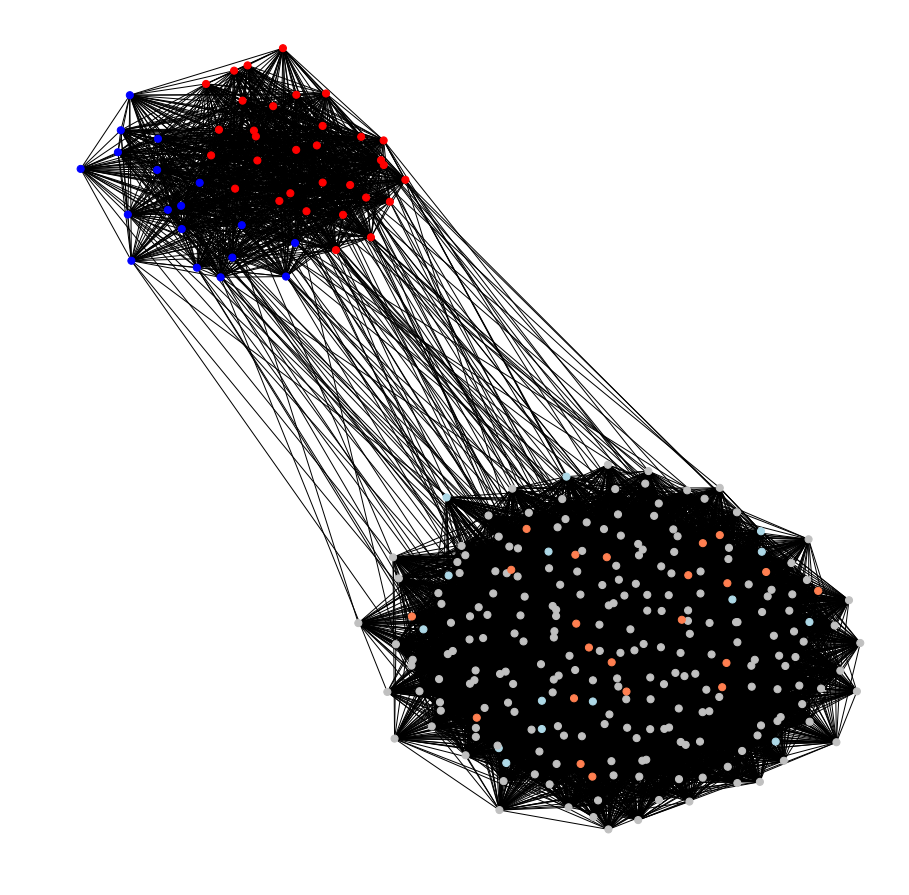

In [294]:
print(nx.info(G))

plt.figure(3,figsize=(12,12)) 
nx.draw_spring(G,node_color=color_map,with_labels=False,node_size = 50)
# nx.draw_spectral(G,with_labels=False,node_size = 20)
plt.show()

In [295]:
np.max(connected_users_length)

134

In [103]:
print('Example of a user in the network with',len(G[8000002]),'connections')
for x in G[8000005].items():
    print(x[0])


Example of a user in the network with 33 connections
8000001
8000002
8000008
8000140
8000026
8000074
8000236
8000147
8000103
8000027
8000029
8000072
8000203
8000076
8000184
8000082
8000064
8000224
8000242
8000093
8000014
8000119
8000228
8000120
8000171
8000080
8000218
8000209
8000086
8000243
8000145
8000063
8000133
8000100
8000159
8000090
8000241
8000167
8000075
8000231
8000125
8000019
8000025
8000036
8000045
8000069
8000085
8000096
8000126
8000136
8000150
8000160
8000221
8000227
8000230


# CONTINUE

### 4.3 Create news artciles to be published by the news sources

In [104]:
FAKE_NEWS_PERCENTAGE = 0.35 #probability that a news article is fake

In [105]:
"""
The goal from the third step of the simulation is to create the news articles
Each news article gets a unique id and a source id which is the news source the article originates from 
The article also has context values such as sentiment, number of shares, and whether it was fake or not
The sources will originate the articles and pass them through the network
If a source knows about the article from another source, they make report the story their way as a new article
The users will decide if they believe the article, they also might occasionally re-train their classifier and assess credibility
Also the users will decide if they want to share the article to their network by adding the article to their portfolio
"""
NEWS_EVENTS_DF = pd.DataFrame(columns=['news_article_id','source_id','source_bias','sentiment','num_shares','fake'])
while NEWS_EVENTS_DF.fake.mean() != FAKE_NEWS_PERCENTAGE:

    #Create news articles with an id, source_id, sentiment, num_shares, fake
    if len(NEWS_EVENTS)> 0:
        NEWS_EVENTS = {}
        NEWS_EVENTS_DF = pd.DataFrame(columns=['news_article_id','source_id','source_bias','sentiment','num_shares','fake'])
    
    article_base = 6000000
    news_fake = int(NUM_NEWS*FAKE_NEWS_PERCENTAGE)
    news_real = NUM_NEWS - news_fake

    for event in range(NUM_NEWS):
        news_article_id = article_base+event
        source_id = random.choice(list(NEWS_SOURCES.keys()))
        num_shares = 0

        r = random.random()
        if (news_fake>0) and (NEWS_SOURCES[source_id].reliable <1) :
            #create a fake article
            sentiment = generate_weighted_sentiment(4,2)
            fake = 1
            news_fake -= 1
        else:
            sentiment = generate_weighted_sentiment(2,1)
            fake = 0
            news_real -= 1


        source_bias = NEWS_SOURCES[source_id].bias
        #generate sentiment
    #     sentiment = random.choice([random.uniform(-5,-1),random.uniform(1,5)])

        #generate num_shares appropriate to the sentiment
    #     lower_bound=int(abs(sentiment))
    #     upper_bound = int(abs(sentiment))**int(abs(sentiment))+1
    #     num_shares = generate_num_of_shares(random.randint(lower_bound,upper_bound),lower_bound)

        #generate a fake score
    #     fake = generate_weighted_percentage(2**abs(sentiment)/2**5)
        #add the news articles

        NEWS_EVENTS[article_base+event] =  NewsArticle(news_article_id,
                                                       source_id,#user_id
                                                       source_bias,
                                                       sentiment, #bias for the user
                                                       num_shares,
                                                       fake) #
        NEWS_EVENTS_DF = NEWS_EVENTS_DF.append(pd.Series([news_article_id,source_id,source_bias,sentiment,num_shares,fake],
                                                         index=NEWS_EVENTS_DF.columns) , ignore_index=True)
    NEWS_EVENTS_DF = NEWS_EVENTS_DF.sample(frac=1).reset_index(drop=True)

In [106]:
NEWS_EVENTS_DF.tail()

news_article_id  source_id  source_bias  sentiment  num_shares  fake
95        6000004.0  1000012.0        -0.32       1.97         0.0   1.0
96        6000023.0  1000027.0         0.57       4.18         0.0   1.0
97        6000069.0  1000008.0        -0.33       3.63         0.0   0.0
98        6000024.0  1000012.0        -0.32       2.40         0.0   1.0
99        6000041.0  1000020.0         0.47       4.76         0.0   0.0

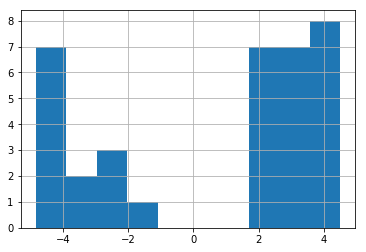

In [107]:
NEWS_EVENTS_DF[NEWS_EVENTS_DF['fake']==1].sentiment.hist()

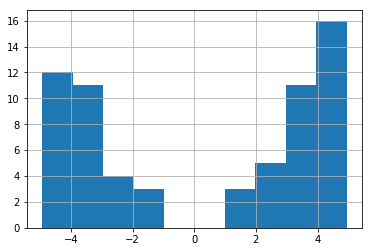

In [108]:
NEWS_EVENTS_DF[NEWS_EVENTS_DF['fake']==0].sentiment.hist()

In [302]:
NEWS_EVENTS_DF['fake'].value_counts()

0.0    65
1.0    35
Name: fake, dtype: int64

### next step is to bring in network evolution to model network changes and bias changes over time

### assign users preference (bias as in statistics and ML not as in value judgement)

### bias is fixed, bias in influencable by conncections, bias is influenced by connections and neighbors

### think of examples for each case: political case, stock market, corona virus

### x  axis fake news %, y axis real p fake

### type of users who misclassify

In [109]:
all_classification_count = 0
misclassification_count = 0
org_fake_clf_real_count = 0
org_real_clf_fake_count = 0
sources_count = 0
users_count = 0

for event in NEWS_EVENTS:
    #Get the event's attributes
    sentiment = NEWS_EVENTS[event].sentiment
    num_shares = NEWS_EVENTS[event].num_shares
    source_id = NEWS_EVENTS[event].source_id
    source_bias = NEWS_SOURCES[source_id].bias
    fake = NEWS_EVENTS[event].fake
    
    print('event ',event,': source',source_id,',sentiment',sentiment,',original number of shares:',num_shares,',fake',fake)
    #create the news article from the source as the first publisher
    NEWS_SOURCES[source_id].add_article(NEWS_EVENTS[event])
    sources_count += 1
    print('News source',source_id,'shared news article',event)
    
    #spread the news and look up user feeds and observe their reactions
    neighbors = list(G.neighbors(source_id))
    visited_neighbors = [] #to_ensure that a visited neighbor does not get repeated 
    visits = 0
    while neighbors:
        neighbor = neighbors.pop(0)
        visited_neighbors.append(neighbor)
        neighbor_is_user = (neighbor/1000000)>7.9
        if neighbor_is_user:
            #assess the source credibility
            bias = USERS[neighbor].bias
            source_credibility = (2-abs(bias-source_bias))/2
            #predict if the news is fake
            classifier_input = np.asarray([bias,source_credibility,sentiment,num_shares]).reshape(1,-1)
            fake_score = np.asscalar(USERS[user].classifier.predict(classifier_input))
            #record the scores
            all_classification_count += 1
            if (fake_score == 1) and (fake == 0):
                org_real_clf_fake_count += 1
                misclassification_count += 1
            if (fake_score == 0) and (fake == 1):
                org_fake_clf_real_count += 1
                misclassification_count += 1
            #make a decision to share the news event
            if fake_score == 1:
                share_prob = generate_weighted_percentage(0.01)
            else:
                share_prob = generate_weighted_percentage(0.1)
            if share_prob == 1:
                #add the article to the list
                USERS[neighbor].add_article(NEWS_EVENTS[event])
                num_shares +=1
                NEWS_EVENTS[event].num_shares += 1
                users_count += 1
                #extend the list to spread the news
                new_neighbors = [x for x in list(G.neighbors(neighbor)) if x not in visited_neighbors]
                neighbors.extend(new_neighbors)
                neighbors = list(dict.fromkeys(neighbors))
#                 print(neighbor,'shared',event,'... New length=',len(neighbors))
        else:
            #news source
#             print(neighbor,'saw that',source_id,' shared event:',event)
            #assess the source credibility
            bias = NEWS_SOURCES[neighbor].bias
            diff = abs(bias-source_bias)
            similarity = (2-diff)/2
#             if(similarity+NEWS_SOURCES[source_id].reliable)>1:
#                 print('similarity:',similarity,'reliable:',NEWS_SOURCES[source_id].reliable)
#             share_prob = generate_weighted_percentage(similarity+NEWS_SOURCES[source_id].reliable)
            share_prob = generate_weighted_percentage(similarity)
            if share_prob == 1:
                #add the article to the list
                NEWS_SOURCES[neighbor].add_article(NEWS_EVENTS[event])
                num_shares +=1
                NEWS_EVENTS[event].num_shares += 1
                sources_count += 1
                #extend the list to spread the news
                new_neighbors = [x for x in list(G.neighbors(neighbor)) if x not in visited_neighbors]
                neighbors.extend(new_neighbors)
                neighbors = list(dict.fromkeys(neighbors))
#                 print(neighbor,'shared',event,'... New length=',len(neighbors))
        visits += 1
    print('# classifications so far:',all_classification_count)
    print('# misclassifications so far:',misclassification_count)
    print('# originally real predicted fake so far:',org_real_clf_fake_count)
    print('# originally fake predicted real so far:',org_fake_clf_real_count)
    print('Sources shared',sources_count,'articles')
    print('Users shared',users_count,'articles')
    print('\n')

event  6000000 : source 1000015 ,sentiment 2.3 ,original number of shares: 0 ,fake 1
News source 1000015 shared news article 6000000
# classifications so far: 239
# misclassifications so far: 239
# originally real predicted fake so far: 0
# originally fake predicted real so far: 239
Sources shared 36 articles
Users shared 24 articles


event  6000001 : source 1000046 ,sentiment -1.67 ,original number of shares: 0 ,fake 0
News source 1000046 shared news article 6000001
# classifications so far: 456
# misclassifications so far: 239
# originally real predicted fake so far: 0
# originally fake predicted real so far: 239
Sources shared 69 articles
Users shared 44 articles


event  6000002 : source 1000002 ,sentiment -2.4 ,original number of shares: 0 ,fake 1
News source 1000002 shared news article 6000002
# classifications so far: 682
# misclassifications so far: 465
# originally real predicted fake so far: 0
# originally fake predicted real so far: 465
Sources shared 106 articles
Users sha

# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 1797 articles
Users shared 1037 articles


event  6000048 : source 1000033 ,sentiment 4.71 ,original number of shares: 0 ,fake 0
News source 1000033 shared news article 6000048
# classifications so far: 11198
# misclassifications so far: 7974
# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 1837 articles
Users shared 1065 articles


event  6000049 : source 1000028 ,sentiment -3.13 ,original number of shares: 0 ,fake 0
News source 1000028 shared news article 6000049
# classifications so far: 11442
# misclassifications so far: 7974
# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 1873 articles
Users shared 1088 articles


event  6000050 : source 1000002 ,sentiment 3.94 ,original number of shares: 0 ,fake 0
News source 1000002 shared news article 6000050
# classifications so far

# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 3530 articles
Users shared 2186 articles


event  6000095 : source 1000017 ,sentiment 2.98 ,original number of shares: 0 ,fake 0
News source 1000017 shared news article 6000095
# classifications so far: 21934
# misclassifications so far: 7974
# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 3568 articles
Users shared 2211 articles


event  6000096 : source 1000006 ,sentiment -4.25 ,original number of shares: 0 ,fake 0
News source 1000006 shared news article 6000096
# classifications so far: 22169
# misclassifications so far: 7974
# originally real predicted fake so far: 0
# originally fake predicted real so far: 7974
Sources shared 3605 articles
Users shared 2237 articles


event  6000097 : source 1000020 ,sentiment -4.5 ,original number of shares: 0 ,fake 0
News source 1000020 shared news article 6000097
# classifications so far

In [110]:
fake_news_ids = NEWS_EVENTS_DF[NEWS_EVENTS_DF['fake']==1].news_article_id.tolist()

In [111]:
fake_news_shares = dict((el,0) for el in fake_news_ids)

In [112]:
for user in USERS:
    for news_article in USERS[user].news_articles:
        if news_article.news_article_id in fake_news_ids:
            fake_news_shares[news_article.news_article_id] += 1
print('Users shared',sum(fake_news_shares.values()),'fake articles')

for news_source in NEWS_SOURCES:
    for news_article in NEWS_SOURCES[news_source].news_articles:
        if news_article.news_article_id in fake_news_ids:
            fake_news_shares[news_article.news_article_id] += 1
print('Total shared',sum(fake_news_shares.values()),'fake articles')

Users shared 759 fake articles
Total shared 2043 fake articles


In [113]:
clear_the_network_from_prev_shares()

Network cleared


### END OF FIRST RUN